# Data Forecasting with prophet


# PROPHET PREDICTION

## TESTO

## Import Dependencies

In [1]:
!pip3 install chart_studio
!pip3 install pystan
!pip3 install fbprophet
!pip3 install glob2
!pip3 install python-dateutil

^C
^C


In [1]:
import os
import itertools
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import datetime 
from datetime import timedelta
import math
import numpy as np
import scipy.stats as st
from fbprophet import Prophet
from influxdb_client import InfluxDBClient
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

In [2]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)


In [3]:
def convert_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)

In [4]:
buckets = [ 'temperature', 'humidity', 'gas']

In [56]:
#With this function we obtain the forecasted data

def bucket_forecast(bucket):
    global mse_array
    global forecasted_array
    global expected_array
    global forecasted
    global expected
    global forecast

    mse_array = []
    forecasted_array = []
    expected_array = []
    forecasted = []
    expected = []
    
    print(bucket)
    query = 'from(bucket: "'+ bucket +'")' \
                ' |> range(start: 2022-11-07T09:00:00.00Z, stop: 2022-11-09T09:00:00.00Z)'\
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "' + bucket +'")' \
                ' |> aggregateWindow(every: 3m , fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    # Convert the results to dataframe
    #dataset_path = open(path[i])
    #df = pd.read_csv(dataset_path)
    df = convert_to_dataframe(result)
    print(df)
    
    #df['ds'] = pd.to_datetime(df['ds'])
    df['ds'] = df['ds'].dt.tz_localize(None)
    
    #train_size 80% - test_size 20%

    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=30,
        n_changepoints=35,
        changepoint_range=1,
        changepoint_prior_scale=0.01
    ).fit(train)
    
    test_interval = int((test.iloc[-1]['ds'].timestamp() - test.iloc[0]['ds'].timestamp()) / 60)
    test_interval = test_interval + 5
    print(test_interval)

    future = m.make_future_dataframe(periods=test_interval, freq= DateOffset(minutes=1))
    forecast = m.predict(future)

    forecast['ds'] = forecast.ds.dt.floor('min')
    test['ds'] = test.ds.dt.floor('min')
    metric = test.set_index('ds')[['y']].join(forecast.set_index('ds').yhat).reset_index()

    metric = metric.dropna()
    
    mse = mean_squared_error(metric['y'], metric['yhat'])
    mse_array.append(mse)
    
    expected_array.append(metric['y'].tolist())
    forecasted_array.append(metric['yhat'].tolist())
    forecasted = list(itertools.chain.from_iterable(forecasted_array))
    expected = list(itertools.chain.from_iterable(expected_array))

    

# evaluate_field('temp')
# print(mse_array)
# print(sum(mse_array)/len(mse_array))

In [23]:
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

temperature
                           ds          y
0   2022-11-07 09:21:00+00:00  16.500000
1   2022-11-07 09:24:00+00:00  16.155556
2   2022-11-07 09:27:00+00:00  16.355932
3   2022-11-07 09:30:00+00:00  16.483333
4   2022-11-07 09:33:00+00:00  16.598611
..                        ...        ...
478 2022-11-08 21:39:00+00:00  17.600000
479 2022-11-08 22:15:00+00:00  17.500000
480 2022-11-08 22:30:00+00:00  17.500000
481 2022-11-08 22:45:00+00:00  17.400000
482 2022-11-08 23:00:00+00:00  17.400000

[483 rows x 2 columns]


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2.81931
473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1750.01    0.00175437        1724.6           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1791.29    0.00170398        1772.2       3.494      0.3494      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1820.49    0.00201164       3451.63           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1831.64   0.000295911       1634.82      0.6433      0.6433      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1838.45    0.00272525       1543.52           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alp

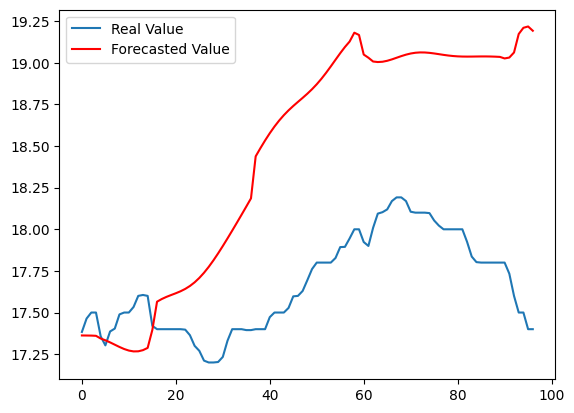

mse
0.8908293529793428
Test RMSE: 0.944
MAE: 0.830527
Mean:  18.442434887000054
Standard Deviation:  0.7055384403039053
Confidence intervals:  (18.299498716391312, 18.585371057608796)
humidity
                           ds          y
0   2022-11-07 09:21:00+00:00  56.516667
1   2022-11-07 09:24:00+00:00  57.363889
2   2022-11-07 09:27:00+00:00  56.403390
3   2022-11-07 09:30:00+00:00  55.851389
4   2022-11-07 09:33:00+00:00  55.468056
..                        ...        ...
478 2022-11-08 21:39:00+00:00  64.450000
479 2022-11-08 22:15:00+00:00  64.450000
480 2022-11-08 22:30:00+00:00  64.400000
481 2022-11-08 22:45:00+00:00  64.600000
482 2022-11-08 23:00:00+00:00  64.550000

[483 rows x 2 columns]
Initial log joint probability = -2.65661
473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       1401.32   0.000375629       835.957   5.181e-07       0.001      112  LS failed, Hessian reset 
      99       1401.55     4.605e-08       

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)




Evaluating humidity


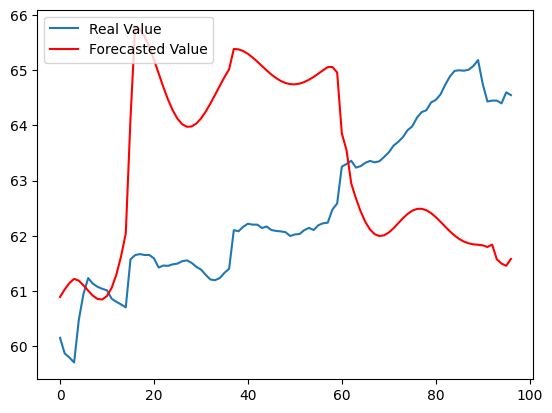

mse
6.230514989257413
Test RMSE: 2.496
MAE: 2.257442
Mean:  63.252091123680046
Standard Deviation:  1.5756533775478174
Confidence intervals:  (62.93287696449632, 63.5713052828638)
gas
                           ds           y
0   2022-11-07 09:21:00+00:00  226.833333
1   2022-11-07 09:24:00+00:00  168.625000
2   2022-11-07 09:27:00+00:00  157.016949
3   2022-11-07 09:30:00+00:00  140.736111
4   2022-11-07 09:33:00+00:00  142.652778
..                        ...         ...
478 2022-11-08 21:39:00+00:00   77.000000
479 2022-11-08 22:15:00+00:00  107.000000
480 2022-11-08 22:30:00+00:00  144.000000
481 2022-11-08 22:45:00+00:00  167.000000
482 2022-11-08 23:00:00+00:00   92.000000

[483 rows x 2 columns]
Initial log joint probability = -3.67706
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1000.89   2.81593e-06       572.793      0.4147           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)




Evaluating gas


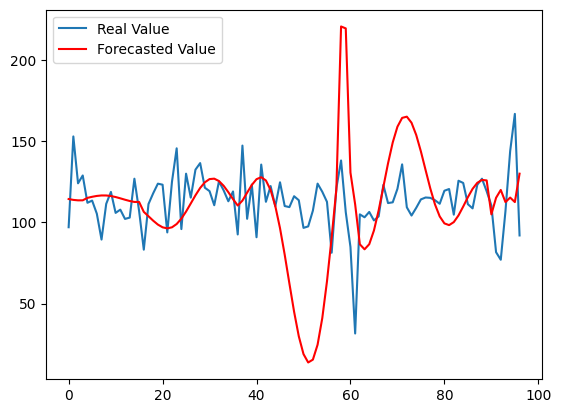

mse
1268.6092472529392
Test RMSE: 35.618
MAE: 24.841511
Mean:  110.6651392365301
Standard Deviation:  32.92040455397138
Confidence intervals:  (103.99574137947151, 117.33453709358862)


In [57]:
APE = []
i = 0
for bucket in buckets:
	bucket_forecast(bucket)
	print("\n\nEvaluating " + bucket)
	plt.plot(expected, label="Real Value")
	plt.plot(forecasted, "-r", label="Forecasted Value")

	plt.legend(loc="upper left")
	plt.show()

	#Mean Square Error & Root Square Error considered more accurate 
	mse = mean_squared_error(expected, forecasted)
	print('mse')
	print(mse) #mah
	rmse = math.sqrt(mean_squared_error(expected, forecasted))
	print('Test RMSE: %.3f'%rmse)

	
	# MAE
	# The mean absolute error, or MAE, 
	# is calculated as the average of the forecast error values, 
	# where all of the forecast error values are forced to be positive.
	# These error values are in the original units of the predicted values. 
	# A mean absolute error of zero indicates no error.

	# Calculate the MAE 
	mae = mean_absolute_error(expected, forecasted)
	print('MAE: %f' % mae)


	# A confidence interval is an estimation technique used in statistical inference to constrain a pair or pairs of values, 
	# within which the desired point estimate will be found (with a certain probability).

	# A confidence interval will allow us to calculate two values around a sample mean (one upper and one lower). 
	# These values will bound an interval within which, with some probability, the population parameter will be found.


	mean = sum(forecasted) / len(forecasted) #mean
	print("Mean: ",mean)


	std = np.std(forecasted)  # standard deviation
	print("Standard Deviation: ",std)

	# create 95% confidence interval
	res = st.t.interval(confidence=0.95, df=len(forecasted)-1,
				loc=np.mean(forecasted),
				scale=st.sem(forecasted))

	print("Confidence intervals: ",res)

	'''lines = [str(forecast["yhat"][d]) for d in range(len(forecast))]
	print(lines)
	lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(forecast["yhat"][d])
									+ ' ' + str(int(time.mktime(forecast['ds'][d].timetuple())) + 3600*2) + "000000000" for d in range(len(forecast))]
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)'''
